## Faster CNN

In [21]:
import numpy as np
import cv2
import torch
import glob
import os
import time
import yaml
import matplotlib.pyplot as plt
import pandas as pd

from models.create_fasterrcnn_model import create_model
from utils.annotations import inference_annotations, convert_detections
from utils.general import set_infer_dir
from utils.transforms import infer_transforms, resize
from utils.logging import LogJSON

In [ ]:
%cd fastercnn-pytorch-training-pipeline

[Errno 2] No such file or directory: 'fastercnn-pytorch-training-pipeline'
/home/jira-dev/WorkSpace-AumJixs/Super_AI_5/Super-AI-Innovator/AI/Train/fastercnn-pytorch-training-pipeline


In [ ]:
class FasterRCNNInference:
    def __init__(self, config):
        # Initialize with configuration dictionary
        self.config = config
        np.random.seed(42)  # For consistent colors
        
        # Setup device
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        # Load model
        self.load_model()
        
        # Prepare output directory
        self.output_dir = config.get('output', set_infer_dir())
        os.makedirs(self.output_dir, exist_ok=True)
        
        # Get class information
        if config.get('data'):
            with open(config['data']) as f:
                self.data_configs = yaml.safe_load(f)
            self.num_classes = self.data_configs['NC']
            self.classes = self.data_configs['CLASSES']
        else:
            # Default COCO config
            with open(os.path.join('data_configs', 'test_image_config.yaml')) as f:
                self.data_configs = yaml.safe_load(f)
            self.num_classes = self.data_configs['NC']
            self.classes = self.data_configs['CLASSES']
            
        self.colors = np.random.uniform(0, 255, size=(len(self.classes), 3))
        
        # Initialize JSON logger if needed
        self.log_json = LogJSON(os.path.join(self.output_dir, 'log.json')) if config.get('log_json') else None
    
    def load_model(self):
        """Load the pretrained model"""
        if not self.config.get('weights'):
            # Load default COCO model
            build_model = create_model.get(
                self.config.get('model', 'fasterrcnn_resnet50_fpn_v2'),
                create_model['fasterrcnn_resnet50_fpn_v2']
            )
            self.model, _ = build_model(num_classes=self.num_classes, coco_model=True)
        else:
            # Load custom weights
            checkpoint = torch.load(self.config['weights'], map_location=self.device)
            
            if not self.config.get('data'):
                self.num_classes = checkpoint['data']['NC']
                self.classes = checkpoint['data']['CLASSES']
                
            build_model = create_model.get(
                self.config.get('model', checkpoint['model_name']),
                create_model[checkpoint['model_name']]
            )
            self.model = build_model(num_classes=self.num_classes, coco_model=False)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            
        self.model.to(self.device).eval()
    
    def process_image(self, image_path):
        """Process a single image"""
        # Read and prepare image
        orig_image = cv2.imread(image_path)
        frame_height, frame_width, _ = orig_image.shape
        
        resize_to = self.config.get('imgsz', frame_width)
        image_resized = resize(
            orig_image, resize_to, square=self.config.get('square_img', False)
        )
        
        # Convert and transform image
        image = cv2.cvtColor(image_resized.copy(), cv2.COLOR_BGR2RGB)
        image = infer_transforms(image)
        image = torch.unsqueeze(image, 0)
        
        # Run inference
        start_time = time.time()
        with torch.no_grad():
            outputs = self.model(image.to(self.device))
        fps = 1 / (time.time() - start_time)
        
        # Process outputs
        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        
        if len(outputs[0]['boxes']) != 0:
            draw_boxes, pred_classes, scores, labels = convert_detections(
                outputs, 
                self.config.get('threshold', 0.3), 
                self.classes,
                self.config
            )
            
            # Draw annotations
            orig_image = inference_annotations(
                draw_boxes, 
                pred_classes, 
                scores,
                self.classes,
                self.colors, 
                orig_image, 
                image_resized,
                self.config
            )
            
            # Visualize if needed
            if self.config.get('show'):
                cv2.imshow('Prediction', orig_image)
                cv2.waitKey(1)
                
            if self.config.get('mpl_show'):
                plt.imshow(orig_image[:, :, ::-1])
                plt.axis('off')
                plt.show()
            
            # Log to JSON if enabled
            if self.config.get('log_json'):
                image_name = os.path.splitext(os.path.basename(image_path))[0]
                self.log_json.update(orig_image, image_name, draw_boxes, labels, self.classes)
            
            return orig_image, draw_boxes, pred_classes, fps
        
        return orig_image, [], [], fps
    
    def run(self):
        """Run inference on all images"""
        # Collect images
        input_path = self.config.get('input', self.data_configs.get('image_path', ''))
        if os.path.isdir(input_path):
            test_images = []
            for ext in ['*.jpg', '*.jpeg', '*.png', '*.ppm']:
                test_images.extend(glob.glob(os.path.join(input_path, ext)))
        else:
            test_images = [input_path]
        
        print(f"Found {len(test_images)} images to process")
        
        # For stats
        total_fps = 0
        frame_count = 0
        pred_boxes = {}
        box_id = 1
        
        for i, image_path in enumerate(test_images):
            image_name = os.path.splitext(os.path.basename(image_path))[0]
            
            # Process image
            result_image, boxes, labels, fps = self.process_image(image_path)
            
            # Save results
            output_path = os.path.join(self.output_dir, f"{image_name}.jpg")
            cv2.imwrite(output_path, result_image)
            
            # Update stats
            total_fps += fps
            frame_count += 1
            
            # Save boxes to table if needed
            if self.config.get('table') and boxes:
                for box, label in zip(boxes, labels):
                    xmin, ymin, xmax, ymax = box
                    width = xmax - xmin
                    height = ymax - ymin
                    
                    pred_boxes[box_id] = {
                        "image": image_name,
                        "label": str(label),
                        "xmin": xmin,
                        "xmax": xmax,
                        "ymin": ymin,
                        "ymax": ymax,
                        "width": width,
                        "height": height,
                        "area": width * height
                    }
                    box_id += 1
            
            print(f"Processed image {i+1}/{len(test_images)}")
            print('-'*50)
        
        # Save boxes table if needed
        if self.config.get('table') and pred_boxes:
            df = pd.DataFrame.from_dict(pred_boxes, orient='index')
            df = df.fillna(0)
            df.to_csv(os.path.join(self.output_dir, "boxes.csv"), index=False)
        
        # Save JSON log if needed
        if self.config.get('log_json'):
            self.log_json.save(os.path.join(self.output_dir, 'log.json'))
        
        # Print summary
        print('INFERENCE COMPLETE')
        if frame_count > 0:
            print(f"Average FPS: {total_fps/frame_count:.3f}")
        print(f"Results saved to: {self.output_dir}")


# Example usage
if __name__ == '__main__':
    # Configuration dictionary - modify these parameters as needed
    config = {
        'input': 'path/to/your/image/or/folder',  # required
        'output': 'output_directory',  # optional
        'data': 'path/to/data_config.yaml',  # optional
        'model': 'fasterrcnn_resnet50_fpn_v2',  # optional
        'weights': None,  # optional path to weights
        'threshold': 0.3,  # detection threshold
        'show': False,  # show images with cv2
        'mpl_show': False,  # show with matplotlib
        'imgsz': None,  # resize size (None for original)
        'no_labels': False,  # don't show labels
        'square_img': False,  # use square resize
        'classes': None,  # filter specific classes
        'log_json': True,  # save JSON log
        'table': True  # save CSV table
    }
    
    # Run inference
    inferencer = FasterRCNNInference(config)
    inferencer.run()

In [20]:
!python inference.py --input /home/jira-dev/WorkSpace-AumJixs/Super_AI_5/Super-AI-Innovator/AI/Train/fastercnn-pytorch-training-pipeline/custom_data/test/Rock-Pigeon.jpg --weights /home/jira-dev/WorkSpace-AumJixs/Super_AI_5/Super-AI-Innovator/AI/Train/fastercnn-pytorch-training-pipeline/outputs/training/custom_training/best_model.pth --th 0.5

Building from model name arguments...
Test instances: 1
Image 1 done...
--------------------------------------------------
TEST PREDICTIONS COMPLETE
Average FPS: 2.226
Path to output files: outputs/inference/res_2


## Yolo

### Image Detection

In [1]:
import cv2
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import clear_output


0: 640x640 1 Eagles, 13.1ms
Speed: 1.6ms preprocess, 13.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 12_jpeg.rf.fe7a1c36db2ed4697857113313aedf88.jpg


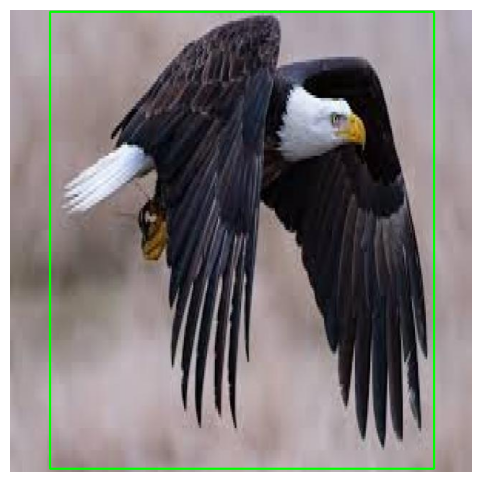




0: 640x640 2 Common-Mynas, 13.3ms
Speed: 1.2ms preprocess, 13.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 140506478_jpg.rf.a6c0e50e57bf207caae4951788ffedcd.jpg


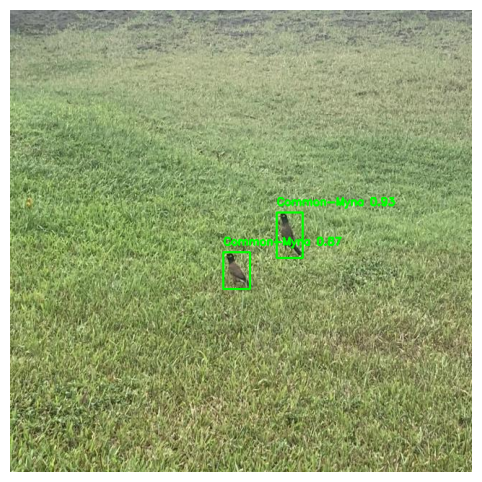




0: 640x640 1 Common-Myna, 13.1ms
Speed: 0.9ms preprocess, 13.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 147213450_jpeg_jpg.rf.4241b7f8474d35c6fccef93da11ad5d1.jpg


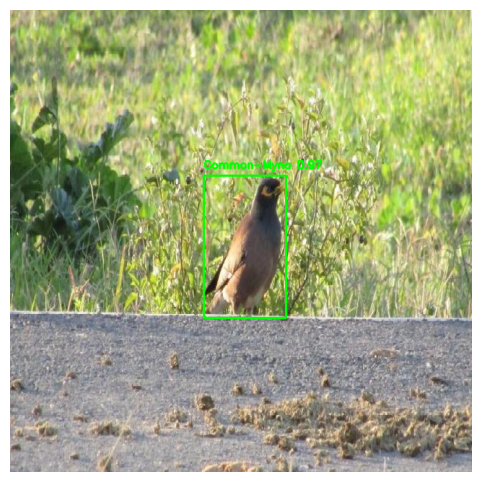




0: 640x640 (no detections), 13.1ms
Speed: 0.9ms preprocess, 13.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 150520753_jpg.rf.a039310e4a71ec680480764171c1b3b3.jpg


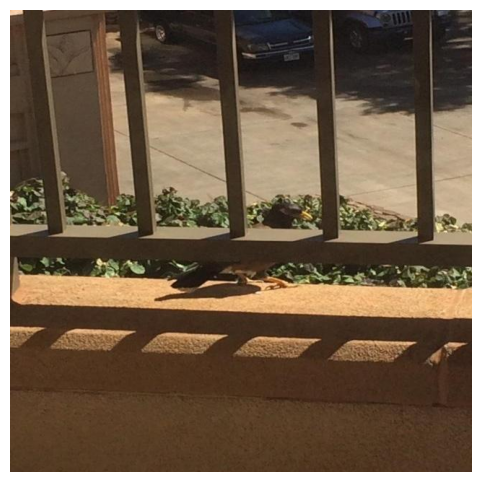




0: 640x640 1 Common-Myna, 13.4ms
Speed: 1.5ms preprocess, 13.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 153958733_jpg.rf.05501ed865479035fb526c4c53b9d2ee.jpg


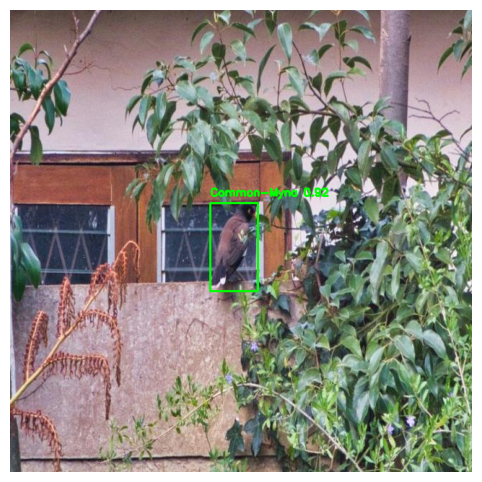




0: 640x640 1 Common-Myna, 13.2ms
Speed: 1.1ms preprocess, 13.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 155152575_jpeg_jpg.rf.ee973941fea85c320fe6329333590bfd.jpg


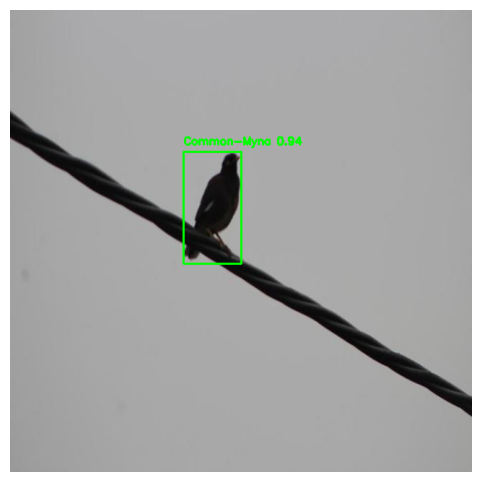




0: 640x640 1 Common-Myna, 13.2ms
Speed: 1.3ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 160798579_jpg.rf.b599cec394597e23be53006336fca51d.jpg


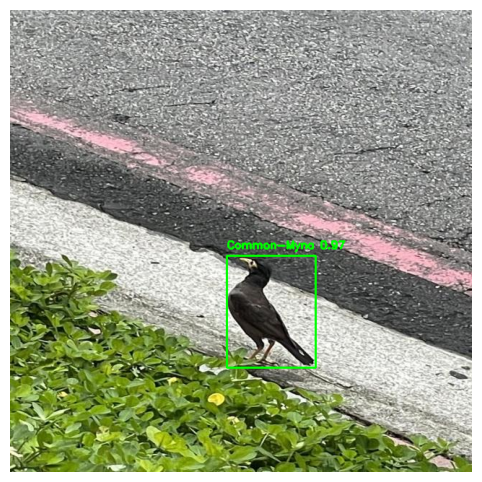




0: 640x640 4 Eagless, 13.2ms
Speed: 1.0ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 1_jpeg.rf.96a8ce86b9e5a7a59e5adbb1a2b38b5a.jpg


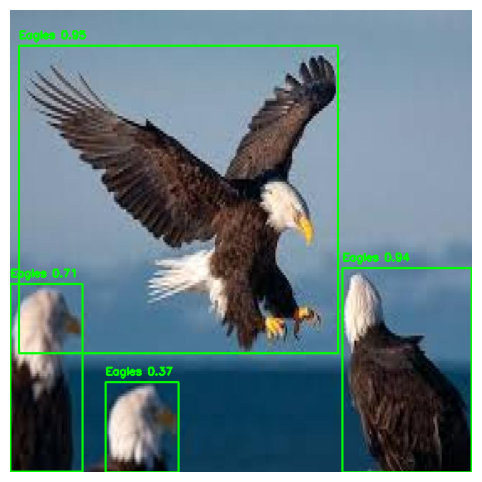




0: 640x640 1 Eagles, 13.1ms
Speed: 1.6ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 20_jpeg.rf.375a0f10fe458814b6ea04d91942e768.jpg


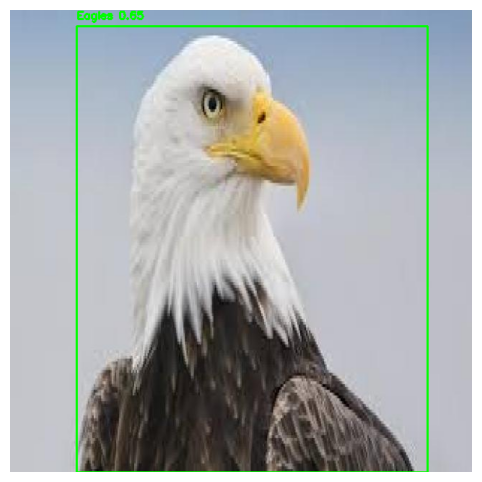




0: 640x640 1 Eagles, 13.2ms
Speed: 0.9ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 32_jpeg.rf.5b34a34bb20124e6152b0752931f5f82.jpg


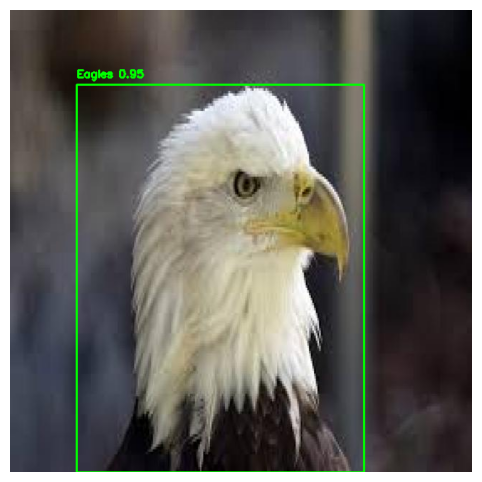




0: 640x640 1 Eagles, 13.2ms
Speed: 1.6ms preprocess, 13.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: 34_jpeg.rf.de55d049c4123d549366d5458a938256.jpg


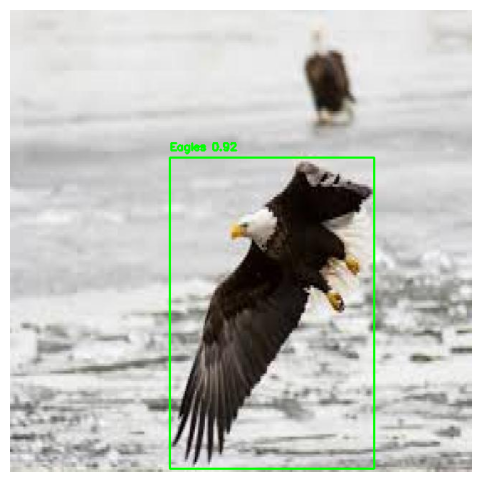




0: 640x640 1 Sparrow, 13.1ms
Speed: 1.6ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: Hama_Burung-24-_jpg.rf.66f40beca33ea8ecc42900e060175e72.jpg


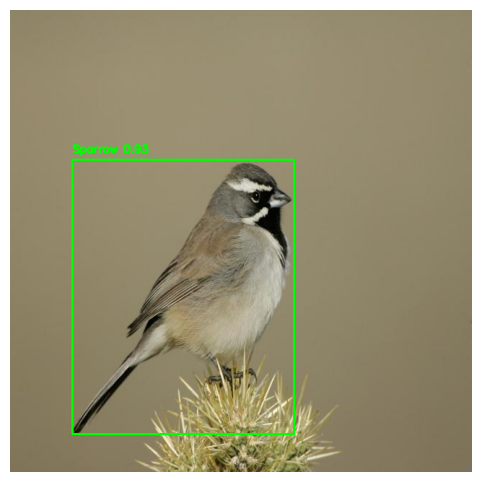




0: 640x640 1 Sparrow, 13.1ms
Speed: 1.0ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: Hama_Burung-42-_jpg.rf.9acd5ee43731b8eaed41e09a999bd247.jpg


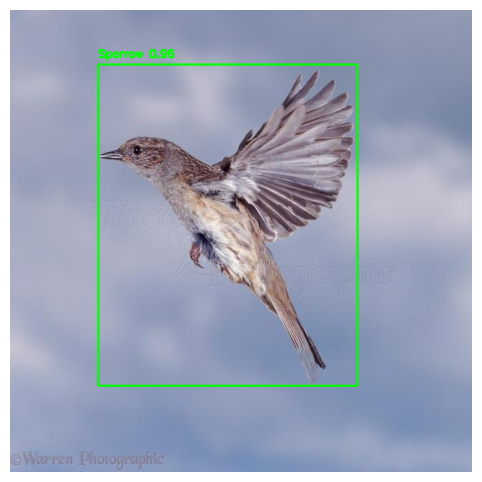




0: 640x640 1 Pigeon, 1 Sparrow, 13.1ms
Speed: 0.8ms preprocess, 13.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: Rock-Pigeon-118_jpg.rf.577f3b1c0f33235cc0e74b3dab30fd5a.jpg


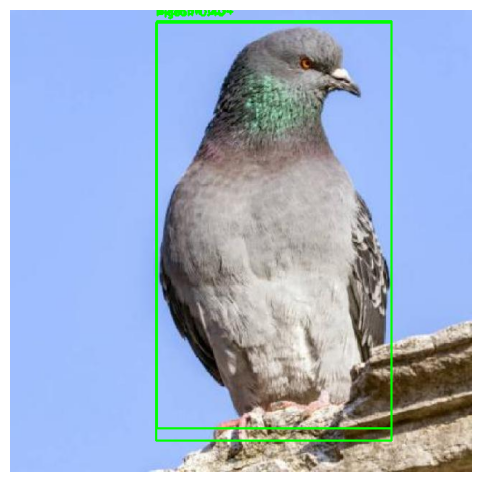




0: 640x640 2 Pigeons, 13.1ms
Speed: 1.2ms preprocess, 13.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: Rock-Pigeon-243_jpg.rf.4613439331a596efc11f38d335e93bb5.jpg


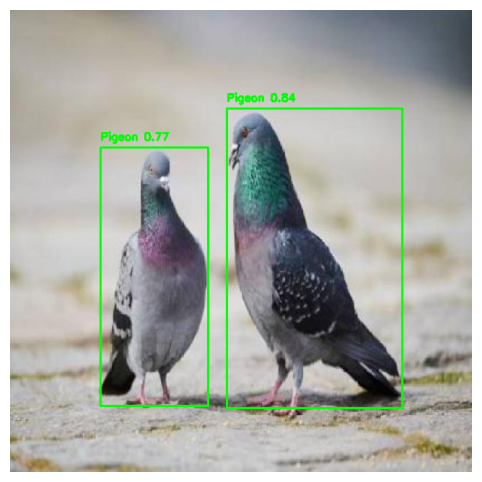




0: 640x640 1 Pigeon, 13.1ms
Speed: 0.8ms preprocess, 13.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
ผลลัพธ์การตรวจจับสำหรับ: Rock-Pigeon-49_jpg.rf.2616e59a5d2ccc6698130e7a815c39a1.jpg


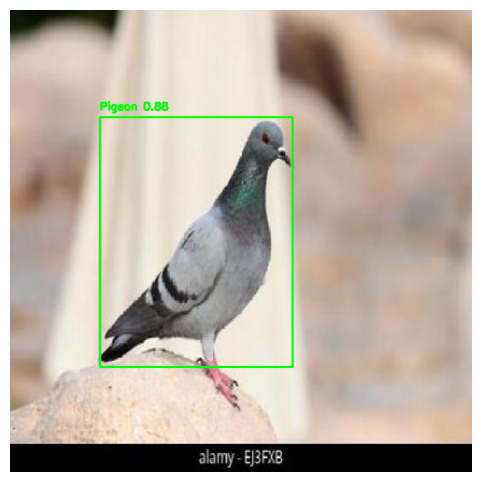




ผลลัพธ์ทั้งหมดถูกบันทึกไว้ในไฟล์ต่อไปนี้:
- detected_12_jpeg.rf.fe7a1c36db2ed4697857113313aedf88.jpg
- detected_140506478_jpg.rf.a6c0e50e57bf207caae4951788ffedcd.jpg
- detected_147213450_jpeg_jpg.rf.4241b7f8474d35c6fccef93da11ad5d1.jpg
- detected_150520753_jpg.rf.a039310e4a71ec680480764171c1b3b3.jpg
- detected_153958733_jpg.rf.05501ed865479035fb526c4c53b9d2ee.jpg
- detected_155152575_jpeg_jpg.rf.ee973941fea85c320fe6329333590bfd.jpg
- detected_160798579_jpg.rf.b599cec394597e23be53006336fca51d.jpg
- detected_1_jpeg.rf.96a8ce86b9e5a7a59e5adbb1a2b38b5a.jpg
- detected_20_jpeg.rf.375a0f10fe458814b6ea04d91942e768.jpg
- detected_32_jpeg.rf.5b34a34bb20124e6152b0752931f5f82.jpg
- detected_34_jpeg.rf.de55d049c4123d549366d5458a938256.jpg
- detected_Hama_Burung-24-_jpg.rf.66f40beca33ea8ecc42900e060175e72.jpg
- detected_Hama_Burung-42-_jpg.rf.9acd5ee43731b8eaed41e09a999bd247.jpg
- detected_Rock-Pigeon-118_jpg.rf.577f3b1c0f33235cc0e74b3dab30fd5a.jpg
- detected_Rock-Pigeon-243_jpg.rf.4613439331a596

In [14]:
import cv2
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import display, Image

# โหลดโมเดล
model = YOLO('/home/jira-dev/WorkSpace-AumJixs/Super_AI_5/Super-AI-Innovator/runs_second/detect/exp_name/weights/best.pt')

# ตั้งค่าโฟลเดอร์รูปภาพ
image_folder = 'AI/Train/Pigeon-1/test/images'

# สร้างลิสต์เพื่อเก็บผลลัพธ์
output_images = []

# ลูปประมวลผลทุกรูปในโฟลเดอร์
for filename in sorted(os.listdir(image_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # อ่านภาพ
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)
        
        # ทำการตรวจจับวัตถุ
        results = model(image)
        
        # วาดผลลัพธ์บนภาพ
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                conf = box.conf[0].item()
                cls_id = box.cls[0].item()
                cls_name = model.names[int(cls_id)]
                
                # วาดสี่เหลี่ยมและข้อความ
                cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                label = f"{cls_name} {conf:.2f}"
                cv2.putText(image, label, (int(x1), int(y1)-10), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # แปลงเป็น RGB สำหรับการแสดงผล
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # บันทึกรูปผลลัพธ์
        output_path = f"detected_{filename}"
        cv2.imwrite(output_path, image)
        output_images.append(output_path)
        
        # แสดงผลใน Jupyter Notebook
        print(f"ผลลัพธ์การตรวจจับสำหรับ: {filename}")
        plt.figure(figsize=(10, 6))
        plt.imshow(image_rgb)
        plt.axis('off')
        plt.show()
        print("\n" + "="*50 + "\n")

# แสดงลิงก์ไปยังผลลัพธ์ทั้งหมดเมื่อประมวลผลเสร็จสิ้น
print("\nผลลัพธ์ทั้งหมดถูกบันทึกไว้ในไฟล์ต่อไปนี้:")
for img_path in output_images:
    print(f"- {img_path}")

### Video Detection

In [16]:
import os
import cv2
from ultralytics import YOLO
import torch
import time

In [29]:
# ตรวจสอบว่า GPU พร้อมใช้งานหรือไม่
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# โหลดโมเดลและส่งไปยัง GPU
model = YOLO('/home/jira-dev/WorkSpace-AumJixs/Super_AI_5/Super-AI-Innovator/runs/detect/exp_name/weights/best.pt').to(device).half()

Using device: cuda


In [30]:
# เปิดวิดีโอ
video_path = '/home/jira-dev/WorkSpace-AumJixs/Super_AI_5/Super-AI-Innovator/Assets/Video/2068519-hd_1920_1080_25fps.mp4'
cap = cv2.VideoCapture(video_path)

# ตั้งค่า confidence threshold
conf_threshold = 0.6

# ตั้งค่าฟอนต์สำหรับข้อความ
font = cv2.FONT_HERSHEY_SIMPLEX

# ตัวแปรสำหรับการติดตามวัตถุ
tracked_objects = set()  # ใช้ set เพื่อเก็บ ID ของวัตถุที่ไม่ซ้ำ
total_unique_objects = 0  # นับวัตถุที่ไม่ซ้ำ
prev_time = 0  # สำหรับคำนวณ FPS

# สร้าง VideoWriter สำหรับบันทึกผลลัพธ์
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # คำนวณ FPS
    current_time = time.time()
    fps_value = 1 / (current_time - prev_time)
    prev_time = current_time
    
    # ใช้ GPU สำหรับการตรวจจับ
    results = model.track(frame, device='cuda', conf=conf_threshold, persist=True)
    
    # วาดผลลัพธ์และนับวัตถุ
    current_frame_objects = 0
    for result in results:
        for box in result.boxes:
            if box.conf[0] >= conf_threshold:
                # รับ ID การติดตาม (หากเปิดใช้งาน tracking)
                obj_id = int(box.id.item()) if box.id is not None else None
                
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                conf = box.conf[0].item()
                cls_id = int(box.cls[0].item())
                cls_name = model.names[cls_id]
                
                # วาด bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # แสดง label และ confidence
                label = f"{cls_name} {conf:.2f}"
                if obj_id is not None:
                    label += f" ID:{obj_id}"
                
                cv2.putText(frame, label, (x1, y1-10), font, 0.6, (0, 255, 0), 2)
                
                current_frame_objects += 1
                
                # นับวัตถุที่ไม่ซ้ำ (ถ้ามี ID การติดตาม)
                if obj_id is not None and obj_id not in tracked_objects:
                    tracked_objects.add(obj_id)
                    total_unique_objects += 1
    
    # แสดงข้อมูลบนเฟรม
    cv2.putText(frame, f'FPS: {fps_value:.2f}', (50, 50), font, 1, (0, 255, 255), 2)
    cv2.putText(frame, f'Current objects: {current_frame_objects}', (50, 90), font, 1, (0, 255, 255), 2)
    cv2.putText(frame, f'Unique objects: {total_unique_objects}', (50, 130), font, 1, (0, 255, 255), 2)
    
    # บันทึกเฟรม
    out.write(frame)
    
    # แสดงผล
    cv2.imshow('Object Detection', frame)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

print(f"การประมวลผลเสร็จสิ้น! พบวัตถุที่ไม่ซ้ำทั้งหมด {total_unique_objects} ชิ้น")


0: 384x640 2 Pigeons, 9.0ms
Speed: 1.3ms preprocess, 9.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Pigeons, 11.7ms
Speed: 2.8ms preprocess, 11.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Pigeons, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 Pigeons, 8.6ms
Speed: 2.1ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)



QObject::moveToThread: Current thread (0x4a9cdc40) is not the object's thread (0x4aae8e10).
Cannot move to target thread (0x4a9cdc40)

QObject::moveToThread: Current thread (0x4a9cdc40) is not the object's thread (0x4aae8e10).
Cannot move to target thread (0x4a9cdc40)

QObject::moveToThread: Current thread (0x4a9cdc40) is not the object's thread (0x4aae8e10).
Cannot move to target thread (0x4a9cdc40)

QObject::moveToThread: Current thread (0x4a9cdc40) is not the object's thread (0x4aae8e10).
Cannot move to target thread (0x4a9cdc40)

QObject::moveToThread: Current thread (0x4a9cdc40) is not the object's thread (0x4aae8e10).
Cannot move to target thread (0x4a9cdc40)

QObject::moveToThread: Current thread (0x4a9cdc40) is not the object's thread (0x4aae8e10).
Cannot move to target thread (0x4a9cdc40)

QObject::moveToThread: Current thread (0x4a9cdc40) is not the object's thread (0x4aae8e10).
Cannot move to target thread (0x4a9cdc40)

QObject::moveToThread: Current thread (0x4a9cdc40) is n

0: 384x640 1 Pigeon, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Pigeon, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Pigeon, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 Pigeons, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Pigeon, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Pigeons, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Pigeons, 8.4ms
Speed: 1.6ms preprocess, 8.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

## !jupyter-notebook